In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
import os
np.set_printoptions(formatter={"float": "{:10.2f}".format})

In [3]:
from src.experiment import Experiment
from src.pycv.dmcp import dm_to_world
mesh_path = "/home/julian/code/uni/ushichka-registration/data/formatted/lidar_roi.ply"
#mesh_path = "C:/Users/Julian/Nextcloud/Uni/Semester 8/ushichka-registration/data/formatted/lidar_roi.ply"
pvMesh = pv.read(mesh_path)

In [10]:
date = "2018-08-18" # 08-14 bad, 08-17 good
day = "/home/julian/data/dmcp_experiments/round_05" + os.sep + date
#day = "/data/dmcp_experiments/round_05" + os.sep + date
def path_day_cam(day,cam):
    exp_path = f"{day}--cam{cam}"
    return exp_path

In [11]:
pc0 = path_day_cam(day,0)
pc1 = path_day_cam(day,1)
pc2 = path_day_cam(day,2)

exp0 = Experiment(pc0,mesh_path)
exp1 = Experiment(pc1,mesh_path)
exp2 = Experiment(pc2,mesh_path)
exps = [exp0, exp1, exp2]

In [12]:
from src.pyushichka import loadCalibration
#date_path = r"C:\data\ushichka" + os.sep + date
date_path = "/home/julian/data/ushichka" + os.sep + date
ps = [loadCalibration(0,date_path),loadCalibration(1,date_path),loadCalibration(2,date_path)]
pts = []
for cam in ps:
    K, P = cam
    #P_trans = P @ la.inv(trans)
    pos = (la.null_space(P) / la.null_space(P)[-1])[:3].flatten()
    pts.append(pos)

pts = np.array(pts)
pts_hat = np.hstack((pts,np.ones((pts.shape[0],1))))
pts_hat

array([[     -2.72,      -0.69,       7.74,       1.00],
       [     -3.11,       0.39,       3.18,       1.00],
       [     -1.39,      -0.26,       8.84,       1.00]])

In [13]:
from dataclasses import dataclass
@dataclass
class TransformedCameras:
    pts: np.ndarray = np.array([])
tcs = []
for exp in exps:
    trans = exp.load_transform()[:3,:]
    tc = TransformedCameras(pts=(trans @ pts_hat.T).T)
    tcs.append(tc)

tcs

[TransformedCameras(pts=array([[      2.49,      -0.75,       0.27],
        [     -0.43,       2.92,      -0.09],
        [      2.21,      -2.41,      -0.30]])),
 TransformedCameras(pts=array([[     -2.64,      -4.10,      -2.97],
        [     -3.38,       0.48,      -2.21],
        [     -3.86,      -5.34,      -3.35]])),
 TransformedCameras(pts=array([[      2.41,      -0.72,       0.36],
        [     -0.52,       2.93,      -0.02],
        [      2.17,      -2.37,      -0.25]]))]

In [14]:
plotter = pv.Plotter(notebook=False)
for i in range(len(tcs)):
    tc = tcs[i]
    sv = pv.PolyData(tc.pts)
    plotter.add_mesh(sv, color=["red","green","blue"][i], point_size=25,render_points_as_spheres=True)
plotter.add_mesh(pvMesh)
plotter.show()

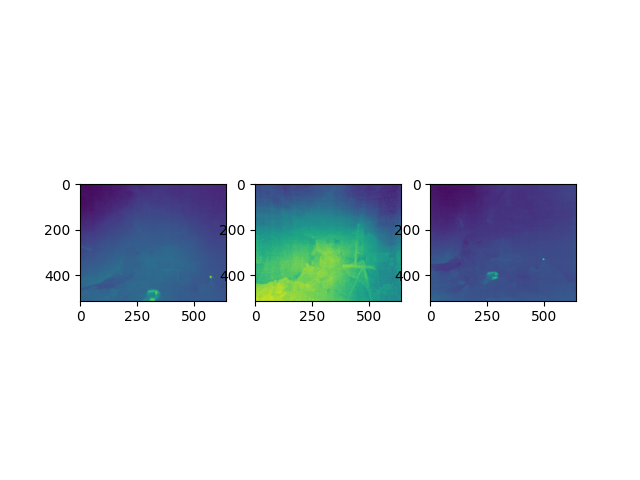

In [15]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(exp0.load_imIm())
plt.subplot(1,3,2)
plt.imshow(exp1.load_imIm())
plt.subplot(1,3,3)
plt.imshow(exp2.load_imIm())
plt.show()